In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
from torchvision import transforms
import torch.optim as optim 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm  # colormaps
%matplotlib inline
from torch.autograd import Variable

#importing Fashion Mnist dataset
transform_list = transforms.Compose([ transforms.ToTensor(), transforms.Normalize(mean=[0.0], std=[1.0,]) ] )
mnist_trainset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_list)
mnist_testset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform_list)

X_train = mnist_trainset.data.numpy()
y_train = mnist_trainset.targets.numpy()
X_test = mnist_testset.data.numpy()
y_test = mnist_testset.targets.numpy()

#smaller dataset to test proof of concept
X_train = X_train[:60000,:,:]
y_train = y_train[:60000]
X_test = X_test[:10000,:,:]
y_test = y_test[:10000]

print(y_train.shape)
print(X_train.shape)
print(y_test.shape)
print(X_test.shape)


(60000,)
(60000, 28, 28)
(10000,)
(10000, 28, 28)


In [2]:
def validity_check(X_train,X_test,y_train,y_test,input_dim,hidden_layer,output_layer,learning_rate,kf):
    X_train_nn = Variable(torch.from_numpy(X_train)).float()
    y_train_nn = Variable(torch.from_numpy(y_train)).long()
    X_test_nn  = Variable(torch.from_numpy(X_test)).float()
    y_test_nn  = Variable(torch.from_numpy(y_test)).long()

    class N_Net( nn.Module ):    
        def __init__(self):
            super(N_Net, self).__init__()
            self.layers = nn.Sequential( 
                nn.Flatten(), 
                nn.Linear(input_dim,hidden_layer[0]),
                nn.ReLU(),
                nn.Linear(hidden_layer[0], hidden_layer[1]), 
                nn.ReLU(),
                nn.Linear(hidden_layer[1], output_layer),
                nn.LogSoftmax(dim=1))
        
        def forward(self, x):
            x1 = self.layers(x)
            return x1
        
    n_Net = N_Net()
    
    def ccp(X_train,X_test,y_train,kf):
        rank_of_folds = None
        for rest_i, fold_i in kf.split(X_train):
            X_rest, X_fold = X_train[rest_i], X_train[fold_i]
            y_rest, y_fold = y_train[rest_i], y_train[fold_i] 
            c_score_fold = n_Net(X_fold).numpy()
            c_score_one = n_Net(X_test).numpy()
            rank_fold = None
            for each in c_score_one:
                rank = np.sum(c_score_fold<each,0)+1
                if rank_fold is None:
                    rank_fold = [rank-1]
                else:
                    rank_fold = np.vstack((rank_fold,[rank-1]))
            if rank_of_folds is None:
                rank_of_folds = [rank_fold]
            else:
                rank_of_folds = np.vstack((rank_of_folds, [rank_fold]))
        sum_ranks = np.sum(rank_of_folds,0)
        p_values = (sum_ranks+1)/len(y_train)
        return(p_values) 
    
    optimizer1 = optim.RMSprop( n_Net.parameters(), lr=learning_rate )
    loss_function = nn.CrossEntropyLoss() 
    true_test_label = y_test_nn.numpy()
    optimizer1.zero_grad()
    y_pred_train_NN = n_Net(X_train_nn)
    loss_NN = loss_function(y_pred_train_NN, y_train_nn)
    #loss_train[epoch] = loss_NN.item()
    loss_NN.backward()
    optimizer1.step()

    with torch.no_grad():
        y_pred_NN = n_Net(X_test_nn).numpy()
        y_p_values_CCP = ccp(X_train_nn,X_test_nn,y_train_nn,kf)

        #plotting calibration curve
        %matplotlib inline
        import matplotlib.pyplot as plt
        significance = np.zeros(100)
        error_rate = np.zeros(100)
        for k in range(100):
            significance[k] = k/100
            error_rate[k] = 0
            for j in range(len(y_test)):
                if (y_p_values_CCP[j,y_test[j]] <= significance[k]):
                    error_rate[k] = error_rate[k] + 1
            error_rate[k] = error_rate[k] / len(y_test)
        from matplotlib.pyplot import figure
        figure(figsize=(8, 6), dpi=80)
        plt.plot(significance,error_rate)
        plt.title('Calibration Curve for Fashion Mnist dataset')
        plt.grid()

        #calculating average false p value
        avg_false_p_value = 0
        row_sum = 0
        r, c = y_p_values_CCP.shape
        for index_l,n in enumerate(y_test):                           
            for p_value_index,m in enumerate(y_p_values_CCP): 
                if index_l == p_value_index: 
                    sum_num = 0
                    for index, o in enumerate(y_p_values_CCP[p_value_index]): 
                        if int(n) != index:                                  
                            sum_num = sum_num+o
                    avg_rowwise = sum_num
                    row_sum = row_sum + avg_rowwise
        avg_false_p_value = row_sum/(y_p_values_CCP.size-r)
    return avg_false_p_value
    

Average false P-value for Cross Conformal Predictor with Neural Network is  0.4774508390740751


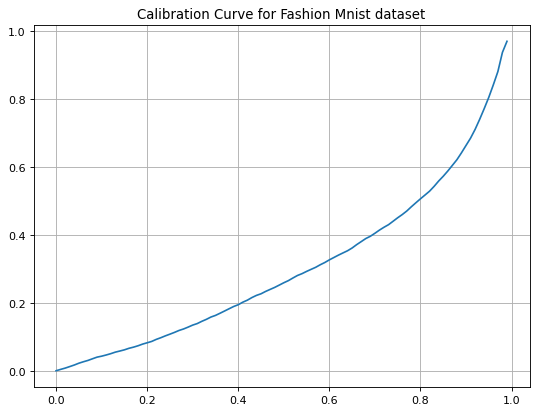

In [3]:
#Hyper parameters
from sklearn.model_selection import KFold 
ran_state = 301
kf = KFold(shuffle=True, random_state=ran_state) 
input_dim = 28*28
hidden_layer = [300,200]
output_layer = 10
learning_rate = 0.0001

avg_false_p_value = validity_check(X_train,X_test,y_train,y_test,input_dim,hidden_layer,output_layer,learning_rate,kf)
print("Average false P-value for Cross Conformal Predictor with Neural Network is ",avg_false_p_value)

In [4]:
def neural_network_with_CCP(X_train,X_test,y_train,y_test,input_dim,hidden_layer,output_layer,learning_rate,epochs,kf):
    X_train_nn = Variable(torch.from_numpy(X_train)).float()
    y_train_nn = Variable(torch.from_numpy(y_train)).long()
    X_test_nn  = Variable(torch.from_numpy(X_test)).float()
    y_test_nn  = Variable(torch.from_numpy(y_test)).long()
    
    class N_Net( nn.Module ):    
        def __init__(self):
            super(N_Net, self).__init__()
            self.layers = nn.Sequential( 
                nn.Flatten(), 
                nn.Linear(input_dim,hidden_layer[0]),
                nn.ReLU(),
                nn.Linear(hidden_layer[0], hidden_layer[1]), 
                nn.ReLU(),
                nn.Linear(hidden_layer[1], output_layer),
                nn.LogSoftmax(dim=1))
        
        def forward(self, x):
            x1 = self.layers(x)
            return x1
        
    n_Net = N_Net()
    
    #cross conformal prediction for Neural Network
    def ccp(X_train,X_test,y_train,kf):
        rank_of_folds = None
        for rest_i, fold_i in kf.split(X_train):
            X_rest, X_fold = X_train[rest_i], X_train[fold_i]
            y_rest, y_fold = y_train[rest_i], y_train[fold_i] 
            c_score_fold = n_Net(X_fold).numpy()
            c_score_one = n_Net(X_test).numpy()
            rank_fold = None
            for each in c_score_one:
                rank = np.sum(c_score_fold<each,0)+1
                if rank_fold is None:
                    rank_fold = [rank-1]
                else:
                    rank_fold = np.vstack((rank_fold,[rank-1]))
            if rank_of_folds is None:
                rank_of_folds = [rank_fold]
            else:
                rank_of_folds = np.vstack((rank_of_folds, [rank_fold]))
        sum_ranks = np.sum(rank_of_folds,0)
        p_values = (sum_ranks+1)/len(y_train)
        return(p_values)   

    loss_train = np.zeros((epochs,))
    loss_test = np.zeros((epochs,))

    accuracy_test_CCP_True = np.zeros((epochs,))
    accuracy_test_NN_True = np.zeros((epochs,))

    optimizer1 = optim.RMSprop( n_Net.parameters(), lr=learning_rate )
    loss_function = nn.CrossEntropyLoss() 
    true_test_label = y_test_nn.numpy()
    error_train = 0

    for epoch in range(epochs):
        total_train = 0
        error_train = 0
        optimizer1.zero_grad()
        y_pred_train_NN = n_Net(X_train_nn)
        loss_NN = loss_function(y_pred_train_NN, y_train_nn)
        
        total_train += y_train_nn.size(0)
        loss_t = loss_NN.item()
        loss_train[epoch] = 100 * loss_t / total_train
        loss_NN.backward()
        optimizer1.step()
        
        
        correct_NN = 0 
        correct_CPP = 0 
        total = 0 
        error_test = 0
        cnn_accuracy = 0
        ccp_accuracy = 0
        
        with torch.no_grad():
            y_pred_NN = n_Net(X_test_nn).numpy()
            y_p_values_CCP = ccp(X_train_nn,X_test_nn,y_train_nn,kf)
            y_hat_CCP = np.argmax(y_p_values_CCP,axis=1)
            y_pred_NN_loss = n_Net(X_test_nn)
            loss_test_CNN = loss_function(y_pred_NN_loss, y_test_nn)
            #loss_test[epoch] = loss_test_CNN.item() 
            error_test = loss_test_CNN.item()
            y_predicted_NN = np.argmax(y_pred_NN,axis = 1)
            correct_NN = np.mean(y_predicted_NN==true_test_label)
            correct_CPP = np.mean(y_hat_CCP==true_test_label)
            total += y_test_nn.size(0)
            
        accuracy_test_NN_True[epoch] = correct_NN
        accuracy_test_CCP_True[epoch] = correct_CPP
        loss_test[epoch] = 100 * error_test / total
           
    return loss_train,loss_test,accuracy_test_NN_True,accuracy_test_CCP_True

In [5]:
#Hyper parameters
from sklearn.model_selection import KFold 
ran_state = 301
kf = KFold(shuffle=True, random_state=ran_state) 
input_dim = 28*28
hidden_layer = [300,200]
output_layer = 10
learning_rate = 0.0001

epochs = 100


loss_train = np.zeros((epochs,))
loss_test = np.zeros((epochs,))
accuracy_test_NN_True = np.zeros((epochs,))
accuracy_test_CCP_True = np.zeros((epochs,))

loss_train, loss_test, accuracy_test_NN_True, accuracy_test_CCP_True = neural_network_with_CCP(X_train,X_test,y_train,y_test,
                                                                                               input_dim,hidden_layer,output_layer,learning_rate,epochs,kf)

In [6]:
print("Training Loss of the model: ",loss_train[-1])  
print("Testing Loss of the model: ",loss_test[-1]) 
print("Accuracy of the model between True Label and NN: ",accuracy_test_NN_True[-1])
print("Accuracy of the model between True Label and CCP: ",accuracy_test_CCP_True[-1])

Training Loss of the model:  0.0010442055265108745
Testing Loss of the model:  0.007051180601119995
Accuracy of the model between True Label and NN:  0.788
Accuracy of the model between True Label and CCP:  0.7974


Text(0.5, 1.0, 'Loss in training and testing data')

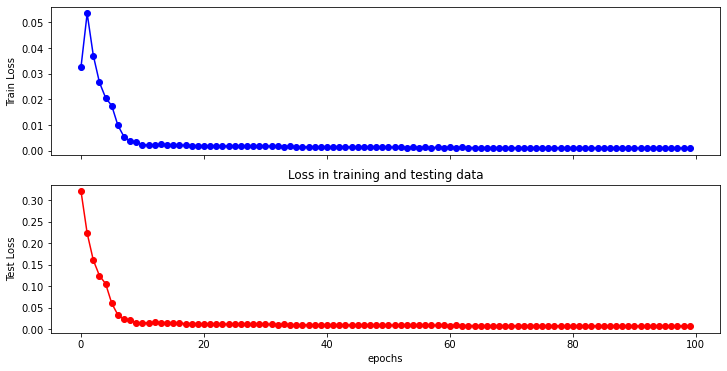

In [7]:
epoch_no = list(range(0, epochs))
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)
ax1.plot(epoch_no, loss_train, 'bo-')
ax1.set_ylabel("Train Loss")
ax2.plot(epoch_no, loss_test, 'ro-')
ax2.set_ylabel("Test Loss")
ax2.set_xlabel("epochs");
plt.title('Loss in training and testing data')

Text(0.5, 1.0, 'Train Loss vs Neural Network Accuracy without Cross Conformal predictor')

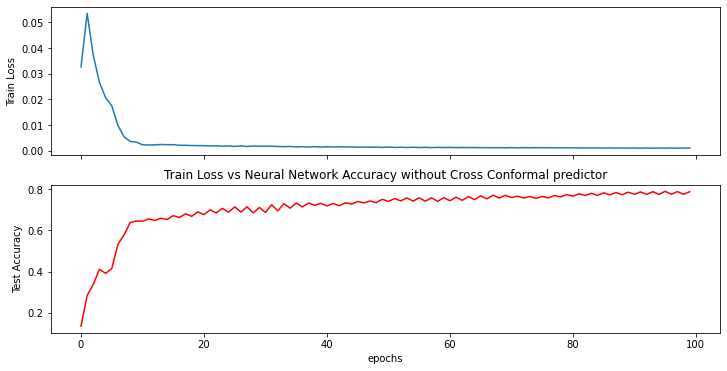

In [8]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)
ax1.plot(loss_train)
ax1.set_ylabel("Train Loss")
ax2.plot(accuracy_test_NN_True, 'r')
ax2.set_ylabel("Test Accuracy")
ax2.set_xlabel("epochs");
plt.title('Train Loss vs Neural Network Accuracy without Cross Conformal predictor')

Text(0.5, 1.0, 'Train Loss vs Neural Network Accuracy with Cross Conformal predictor')

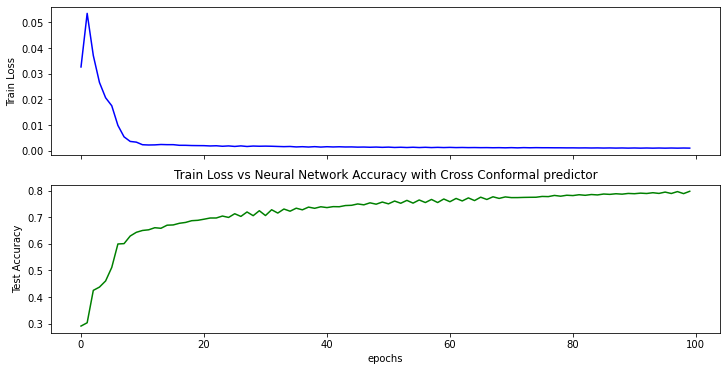

In [9]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(loss_train, color = 'b')
ax1.set_ylabel("Train Loss")
ax2.plot(accuracy_test_CCP_True, color='g')
ax2.set_ylabel("Test Accuracy")
ax2.set_xlabel("epochs");
plt.title('Train Loss vs Neural Network Accuracy with Cross Conformal predictor')

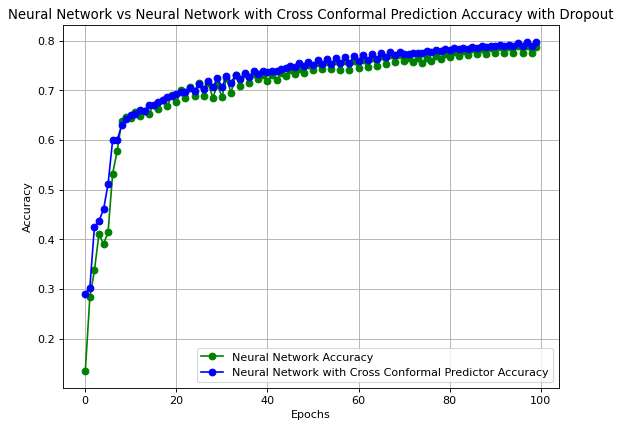

In [10]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)

epoch_no = list(range(0, epochs))
plt.plot(epoch_no, accuracy_test_NN_True, 'go-')
plt.plot(epoch_no, accuracy_test_CCP_True, 'bo-')
plt.title('Neural Network vs Neural Network with Cross Conformal Prediction Accuracy with Dropout')
plt.legend(('Neural Network Accuracy','Neural Network with Cross Conformal Predictor Accuracy'))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()

In [11]:
#implementing in built scikit-learn MLPClassifier model
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

X, y = fetch_openml('Fashion-MNIST', version=1, return_X_y=True)

In [12]:
X_train_inbuilt, X_test_inbuilt = X[:60000], X[60000:]
y_train_inbuilt, y_test_inbuilt = y[:60000], y[60000:]

In [13]:
import warnings
warnings.filterwarnings('ignore')

mlp = MLPClassifier(hidden_layer_sizes=(300,200 ), max_iter=100, alpha=1e-4, 
                    solver='adam', verbose=False, random_state=301, 
                    learning_rate_init=.0001,tol = 0.0000000001, n_iter_no_change=100)


In [14]:
fit_training_data = mlp.fit(X_train_inbuilt, y_train_inbuilt)
predictions_train = mlp.predict(X_train_inbuilt)
train_score = accuracy_score(predictions_train, y_train_inbuilt)
print("Accuracy for training data: ", train_score)

Accuracy for training data:  0.9890833333333333


In [15]:
fit_data_test = mlp.fit(X_test_inbuilt, y_test_inbuilt)
predictions_test = mlp.predict(X_test_inbuilt)
test_score = accuracy_score(predictions_test, y_test_inbuilt)
print("Accuracy for testing data: ", test_score)

Accuracy for testing data:  1.0


Loss from Scikit learn MLP Classifier 0.00040968513779838627
100


Text(0.5, 1.0, 'scikit learn Neural Network model vs our Cross Conformal model with Neural Network')

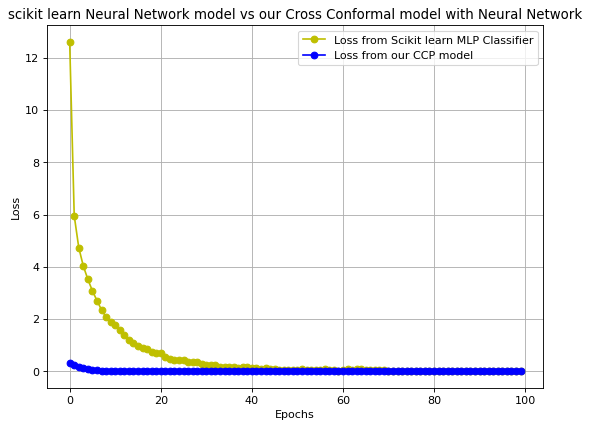

In [16]:
#100 epochs full dataset
print('Loss from Scikit learn MLP Classifier',mlp.loss_)
print(len(mlp.loss_curve_[:epochs]))
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)
plt.plot(epoch_no, mlp.loss_curve_[:epochs], 'yo-')
plt.plot(epoch_no, loss_test[:epochs], 'bo-')
plt.legend(('Loss from Scikit learn MLP Classifier','Loss from our CCP model'))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.title('scikit learn Neural Network model vs our Cross Conformal model with Neural Network')